# Lab1: LeNet
---

## 1 模型结构
本次实验实现的模型为`LeNet5`，在`CIFAR-10`数据集上进行分类实验。CIFAR-10数据集是彩色带标签图像数据集，
每张图像尺寸为$32\times 32$。因此图像具有3个通道，模型输入为$3\times 32 \times 32$。

模型结构依次如下：
- 卷积层1：图像输入深度=3，图像输出深度/卷积核个数=16，卷积核大小=$5\times 5$，步长=1
    （输入矩阵：$3\times 32\times 32$，输出矩阵：$16\times 28\times 28$）
- 池化层1：过滤器大小=$2\times 2$，步长=2
    （输出矩阵：$16\times 14\times 14$）
- 卷积层2：图像输入深度=卷积层1输出深度=16，图像输出深度=32，卷积核大小=$5\times 5$，步长=1
    （输出矩阵：$32\times 10\times 10$）
- 池化层2：过滤器大小=$2\times 2$，步长=2
    （输出矩阵：$32\times 5\times 5$）
- 全连接层1：输出节点120个
- 全连接层2：输出节点84个
- 全连接层3：输出节点10个

本次实验用到的库如下：

In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image

In [9]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        # convolution layer1
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1)
        # pool layer1
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        # convolution layer2
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1)
        # pool layer2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # fully connected layer1
        self.fc1 = nn.Linear(32*5*5,120)
        # fully connected layer2
        self.fc2 = nn.Linear(120,84)
        # fully connected layer3
        self.fc3 = nn.Linear(84,10)

    def forward(self,x):
        # convolution -> activation function -> pool
        x = F.relu(self.conv1(x))  # conv(3*32*32) -> activation(16*28*28)
        x = self.pool1(x)  # activation -> pool
        x = F.relu(self.conv2(x))
        x = self.pool2(x) 
        # reshape the output size automatically into 32*5*5
        x = x.view(-1, 32 * 5 * 5)  
        # fully connected -> activation function
        x = F.relu(self.fc1(x))  # output(120)
        x = F.relu(self.fc2(x))  # output(84)
        x = self.fc3(x)  # output(10)
        return x

`LeNet`类继承自`nn.Module`类，包括初始化函数和前向传播函数。本次实验使用`relu`函数作为激活函数，克服梯度消失问题。

---

## 2 数据集处理
从`torchvision.datasets`中下载数据集，包括训练集和测试集。

使用`transforms.Compose`拼接函数，使用`ToTensor`将Image转化为tensor格式，然后使用`normalize`将tensor标准化/归一化，加快模型收敛。

In [10]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# load data
trainloader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False)
# the dataset's classes names
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


batch大小设置为4张图片。

查看数据集中的数据情况，打印出一个batch。从数据集中直接获取到的image是tensor形式，需要反标准化将tensor转换成图像。使用`show`函数实现。

      truck         car         dog        ship


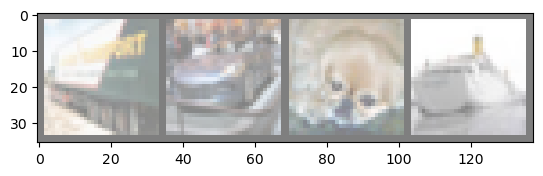

In [11]:
def show(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    # pytorch presentation: [channel, height, width]
    # plt use numpy: [height, width, channel]
    # use np.transpose() to change axis order
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.__next__()  # return 4 pics and labels
print(' '.join('%11s' % classes[labels[j]] for j in range(4)))  # print labels
show(torchvision.utils.make_grid((images + 1) / 2))

----

## 3 训练模型

使用交叉熵损失函数，同时选择Adam优化器优化，学习率设为0.001

In [47]:
# use cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = LeNet()
net_model = net.to(device)

loss_function = nn.CrossEntropyLoss()
# choose Adam to optimize, learning rate=0.001
optimizer = optim.Adam(net.parameters(), lr=0.001)

max_epoch = 100

训练总共进行100轮，训练过程中计算每一轮训练的平均损失和总体准确率，绘制出损失函数变化和整体准确率变化。

In [48]:
loss_per_epoch = []
accuracy_per_epoch = []

for epoch in range(max_epoch):
    print("Begin epoch %i"% (epoch+1))
    Loss = []
    Accuracy = []
    total = 0
    correct = 0
    for i, data in enumerate(trainloader,0):
        inputs, labels = data
        # load input and label data into gpu
        inputs, labels = inputs.to(device), labels.to(device)
        # make gradient zero
        optimizer.zero_grad()
        # forward
        output = net_model(inputs)
        loss = loss_function(output,labels)

        # get current predict to show training status
        predict = output.argmax(dim=1)
        total += labels.size(0)
        correct += (predict==labels).sum().item()

        # backward, generate gradient automatically
        loss.backward()
        optimizer.step()

        if i % 2000 == 1999:
            Loss.append(loss.item())

    loss_per_epoch.append(np.array(Loss).mean())
    accuracy_per_epoch.append(correct/total)
    print("Epoch %(epoch)i  loss: %(loss)f, accuracy: %(accr)f" \
          % {"epoch":epoch+1,"loss":np.array(Loss).mean(),"accr":correct/total})
print("Train finished.")

Begin epoch 1
Epoch 1  loss: 1.323563, accuracy: 0.438240
Begin epoch 2
Epoch 2  loss: 1.465763, accuracy: 0.541520
Begin epoch 3
Epoch 3  loss: 0.939766, accuracy: 0.588620
Begin epoch 4
Epoch 4  loss: 1.367349, accuracy: 0.621100
Begin epoch 5
Epoch 5  loss: 0.967714, accuracy: 0.645940
Begin epoch 6
Epoch 6  loss: 0.555698, accuracy: 0.661360
Begin epoch 7
Epoch 7  loss: 1.143704, accuracy: 0.677860
Begin epoch 8
Epoch 8  loss: 0.887163, accuracy: 0.686560
Begin epoch 9
Epoch 9  loss: 1.021560, accuracy: 0.700500
Begin epoch 10
Epoch 10  loss: 0.694891, accuracy: 0.707900
Begin epoch 11
Epoch 11  loss: 0.804333, accuracy: 0.714540
Begin epoch 12
Epoch 12  loss: 0.943603, accuracy: 0.721960
Begin epoch 13
Epoch 13  loss: 0.597413, accuracy: 0.729340
Begin epoch 14
Epoch 14  loss: 0.645795, accuracy: 0.734160
Begin epoch 15
Epoch 15  loss: 0.461726, accuracy: 0.739880
Begin epoch 16
Epoch 16  loss: 0.637428, accuracy: 0.746620
Begin epoch 17
Epoch 17  loss: 0.690866, accuracy: 0.75242

将模型训练过程loss和accuracy的变化用matplotlib绘制出来。

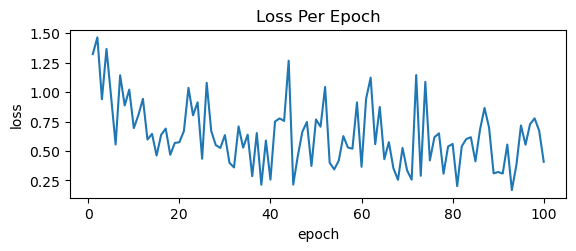

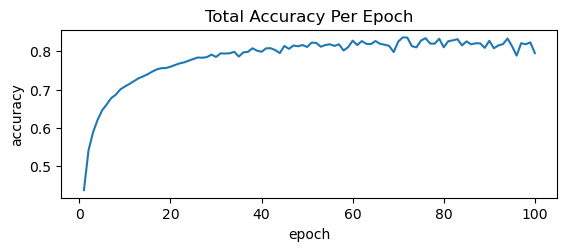

In [50]:
epochs = [i+1 for i in range(max_epoch)]

plt.subplot(211)
plt.plot(epochs,loss_per_epoch)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss Per Epoch")
plt.show()

plt.subplot(212)
plt.plot(epochs,accuracy_per_epoch)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Total Accuracy Per Epoch")
plt.show()

平均loss的波动较大，整体趋势随着训练轮数增加减小。训练集上的准确率随着训练增加，但是在达到80%左右后不断波动，没有进一步提升。可能存在过拟合的风险。

打印出模型基本信息并将模型权重文件保存到文件目录中。

In [51]:
print(net_model)
torch.save(net_model.state_dict(), './models/model-cifar10-100.pth')

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


----

## 4 测试模型
计算模型在10000张测试集上的准确率。

In [52]:
correct = 0
total = 0
# torch.no_grad() do not calculate gradient
# do not backward
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net_model(images)
        # torch.max(outputs.data, 1)returns the max index
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print('Accuracy of the network: %d %%' % (100 * correct / total))
 
# print accuracy for each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10)) 
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net_model(images) # outputs dimension：4*10
        _, predicted = torch.max(outputs, 1) # predicted dimension: 4*1
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network: 65 %
Accuracy of plane : 64.600000 %
Accuracy of   car : 75.400000 %
Accuracy of  bird : 55.400000 %
Accuracy of   cat : 40.500000 %
Accuracy of  deer : 48.700000 %
Accuracy of   dog : 64.600000 %
Accuracy of  frog : 71.700000 %
Accuracy of horse : 71.600000 %
Accuracy of  ship : 75.100000 %
Accuracy of truck : 82.500000 %


网络整体在测试集上的正确率为65%，每个分类的正确率基本上在60%-70%左右。

选择一张不在数据集中的图片进行测试。

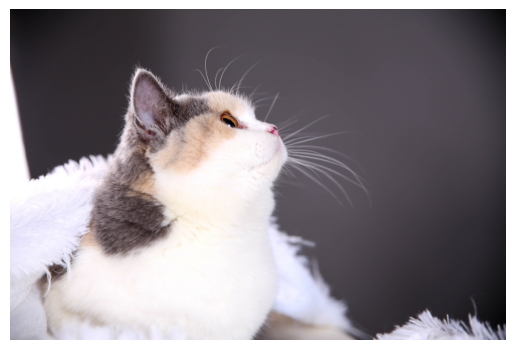

cat


In [53]:
# load the trained model
model = LeNet()
model.load_state_dict(torch.load('./models/model-cifar10.pth'))

pic = Image.open('test_cat.jpg')
plt.imshow(pic)
plt.axis('off') 
plt.show() # show original picture
    
# use trans to format input pic
trans = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
img = trans(pic)
# expand the input into 4 dimension: [batchsize, channel, width, height]
img = img.unsqueeze(0)

with torch.no_grad():
    output = model(img)
    predict = torch.max(output, dim=1)[1]
print(classes[predict.item()])

预测正确，网络整体准确率相对较为可观，达到了65%，远超10%的随机预测值。

----

## 参考资料
1. https://blog.csdn.net/qq_51363161/article/details/124215713